# Set-up

In [1]:
# import packages
import random

# manipulation 
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
import missingno as msno
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# modelling
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

# metrics
from sklearn.metrics import r2_score, mean_squared_error

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

RSEED = 394

In [2]:
# load data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Data Inspection

## Size of data

In [3]:
print(f"Shape of modelling dataset: {df_train.shape}")
print(f"Shape of prediction] dataset: {df_test.shape}")

Shape of modelling dataset: (30557, 82)
Shape of prediction] dataset: (16136, 77)


### Which columns differ? 

In [4]:
diff_cols = [col for col in df_train.columns if col not in df_test.columns]
diff_cols

['target', 'target_min', 'target_max', 'target_variance', 'target_count']

## Data features 

In [5]:
poll_cols = [col for col in df_train.columns if col.find('L3') != -1]
target_cols = [col for col in df_train.columns if col.find('target') != -1]
loc_cols = [col for col in df_train.columns if col.find('Place') != -1 or col.find('Date') != -1 ]
weather_cols = [col for col in df_train.columns if col not in poll_cols + target_cols + loc_cols ]

print(f"Number of columns related to:")
print(f"target: {len(target_cols)}")
print(f"pollution: {len(poll_cols)}")
print(f"location: {len(loc_cols)}")
print(f"weather: {len(weather_cols)}")


Number of columns related to:
target: 5
pollution: 68
location: 3
weather: 6


### How many places and dates do we have? 

In [6]:
df_train.Date.unique()
print(f"There are {df_train.Date.nunique()} dates between {df_train.Date.min()} and {df_train.Date.max()}.")

df_train.Place_ID.unique()
print(f"The number of places is {df_train.Place_ID.nunique()}.")

There are 94 dates between 2020-01-02 and 2020-04-04.
The number of places is 340.


In [7]:
print(f"We have {df_train.shape[0]} actual observations.")
print(f"If each place had the full 3 months of observations, we should have a sample size of {94 * 340}.")

print(f"\nThis means we do NOT have observations for each place-date pair.")

We have 30557 actual observations.
If each place had the full 3 months of observations, we should have a sample size of 31960.

This means we do NOT have observations for each place-date pair.


In [8]:
place_counts = df_train.groupby('Place_ID').Place_ID.count().unique()
print(f"A place appears between {place_counts.min()} and {place_counts.max()} times.")

A place appears between 3 and 94 times.


### How many pollutants do we have? 

In [9]:
# list_of_pollutants = [NO2, CH4, ....]
pollutants = list(set([pol.split('_')[1] for pol in df_train[poll_cols].columns]))
pollutants = [pol + "_AI" if pol == "AER" else pol for pol in pollutants]

pollutants

['CH4', 'HCHO', 'CO', 'SO2', 'NO2', 'O3', 'AER_AI', 'CLOUD']

## Target variables

In [10]:
df_train[target_cols].head()

,target,target_min,target_max,target_variance,target_count
0,38.0,23.0,53.0,769.50,92
1,39.0,25.0,63.0,1319.85,91
2,24.0,8.0,56.0,1181.96,96
3,49.0,10.0,55.0,1113.67,96
4,21.0,9.0,52.0,1164.82,95


# 2. Data preparation

## Split train and test

Later in this notebook, we perform within-place imputation of various pollutant-related variables. This means we must split dataset into train and test data such that each city appears _either_ in the train data _or_ the test data (but not both). 

We do this by randomly splitting the list of unique places. Based on this split, we then subset the entire dataset (place-date pairs). 

In [11]:
df = df_train.copy()

# split dataset into features and target
y = df[['target', 'Place_ID']]          # keep place_ID because we need it for the train/test split
X = df.drop(target_cols, axis = 1)

# obtain unique list of places
places = X.Place_ID.unique()

# split the cities into train and test
places_train, places_test = train_test_split(places, test_size=0.2, random_state=RSEED)

# filter the features for train and test cities
X_train = X[X['Place_ID'].isin(places_train)]
X_test = X[X['Place_ID'].isin(places_test)]

# filter the targets for train and test (+ drop the location variable)
y_train = y[y['Place_ID'].isin(places_train)].drop('Place_ID', axis = 1)
y_test = y[y['Place_ID'].isin(places_test)].drop('Place_ID', axis = 1)

# append features and targets for EDA
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

# display the shapes of train and test sets
print(f"Number of places in test is {len(places_test)} and in train {len(places_train)}.")
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Split percentage on set:", round(X_train.shape[0]/len(X)*100, 4), "%")


Number of places in test is 68 and in train 272.
Train set shape: (24533, 77)
Test set shape: (6024, 77)
Split percentage on set: 80.286 %


In [12]:
# drop all columns with satellite position information --> not relevant for prediction
useless_cols = [col for col in poll_cols if col.find('sensor') != -1 or col.find('solar') != -1]
print("The pollution features of interest are:")
print(useless_cols)

poll_cols = [col for col in poll_cols if col not in useless_cols]

X_train = X_train.drop(useless_cols, axis = 1)
X_test = X_test.drop(useless_cols, axis = 1)

The pollution features of interest are:
['L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle', 'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle', 'L3_NO2_solar_zenith_angle', 'L3_O3_sensor_azimuth_angle', 'L3_O3_sensor_zenith_angle', 'L3_O3_solar_azimuth_angle', 'L3_O3_solar_zenith_angle', 'L3_CO_sensor_altitude', 'L3_CO_sensor_azimuth_angle', 'L3_CO_sensor_zenith_angle', 'L3_CO_solar_azimuth_angle', 'L3_CO_solar_zenith_angle', 'L3_HCHO_sensor_azimuth_angle', 'L3_HCHO_sensor_zenith_angle', 'L3_HCHO_solar_azimuth_angle', 'L3_HCHO_solar_zenith_angle', 'L3_CLOUD_sensor_azimuth_angle', 'L3_CLOUD_sensor_zenith_angle', 'L3_CLOUD_solar_azimuth_angle', 'L3_CLOUD_solar_zenith_angle', 'L3_AER_AI_sensor_altitude', 'L3_AER_AI_sensor_azimuth_angle', 'L3_AER_AI_sensor_zenith_angle', 'L3_AER_AI_solar_azimuth_angle', 'L3_AER_AI_solar_zenith_angle', 'L3_SO2_sensor_azimuth_angle', 'L3_SO2_sensor_zenith_angle', 'L3_SO2_solar_azimuth_angle', 'L3_SO2_solar_zenith_angle', 'L3_CH4_sensor_azimuth_

# Exploratory data analysis & feature engineering

## Distributions of features

In [13]:
y_train.describe()

,target
count,24533.000000
mean,60.112779
std,47.344209
min,1.000000
25%,25.000000
50%,50.000000
75%,77.000000
max,815.000000


[here should be more code for distributions]

## Relationships among features

tbw

## Missing values

There are no missing values for location and weather variables. 

Polution related features have missing values, which are missing in groups on the pollutant level. For instance, if we have 6 variables for methane, values for an observation are either all missing or all non-missing.

We assess the missing values, finding that missing values are distributed across the entire 3-month period and across the different cities (i.e. we do _not_ have a situation in which only some cities or some months have observations for a pollutant). 

Hence, we decide to use linear interpolation for each pollutant on the city level over time. 

### Inspection

In [14]:
X_train.isnull().sum()

Place_ID X Date                                            0
Date                                                       0
Place_ID                                                   0
precipitable_water_entire_atmosphere                       0
relative_humidity_2m_above_ground                          0
specific_humidity_2m_above_ground                          0
temperature_2m_above_ground                                0
u_component_of_wind_10m_above_ground                       0
v_component_of_wind_10m_above_ground                       0
L3_NO2_NO2_column_number_density                        1750
L3_NO2_NO2_slant_column_number_density                  1750
L3_NO2_absorbing_aerosol_index                          1750
L3_NO2_cloud_fraction                                   1750
L3_NO2_stratospheric_NO2_column_number_density          1751
L3_NO2_tropopause_pressure                              1751
L3_NO2_tropospheric_NO2_column_number_density           6957
L3_O3_O3_column_number_d

<Axes: >

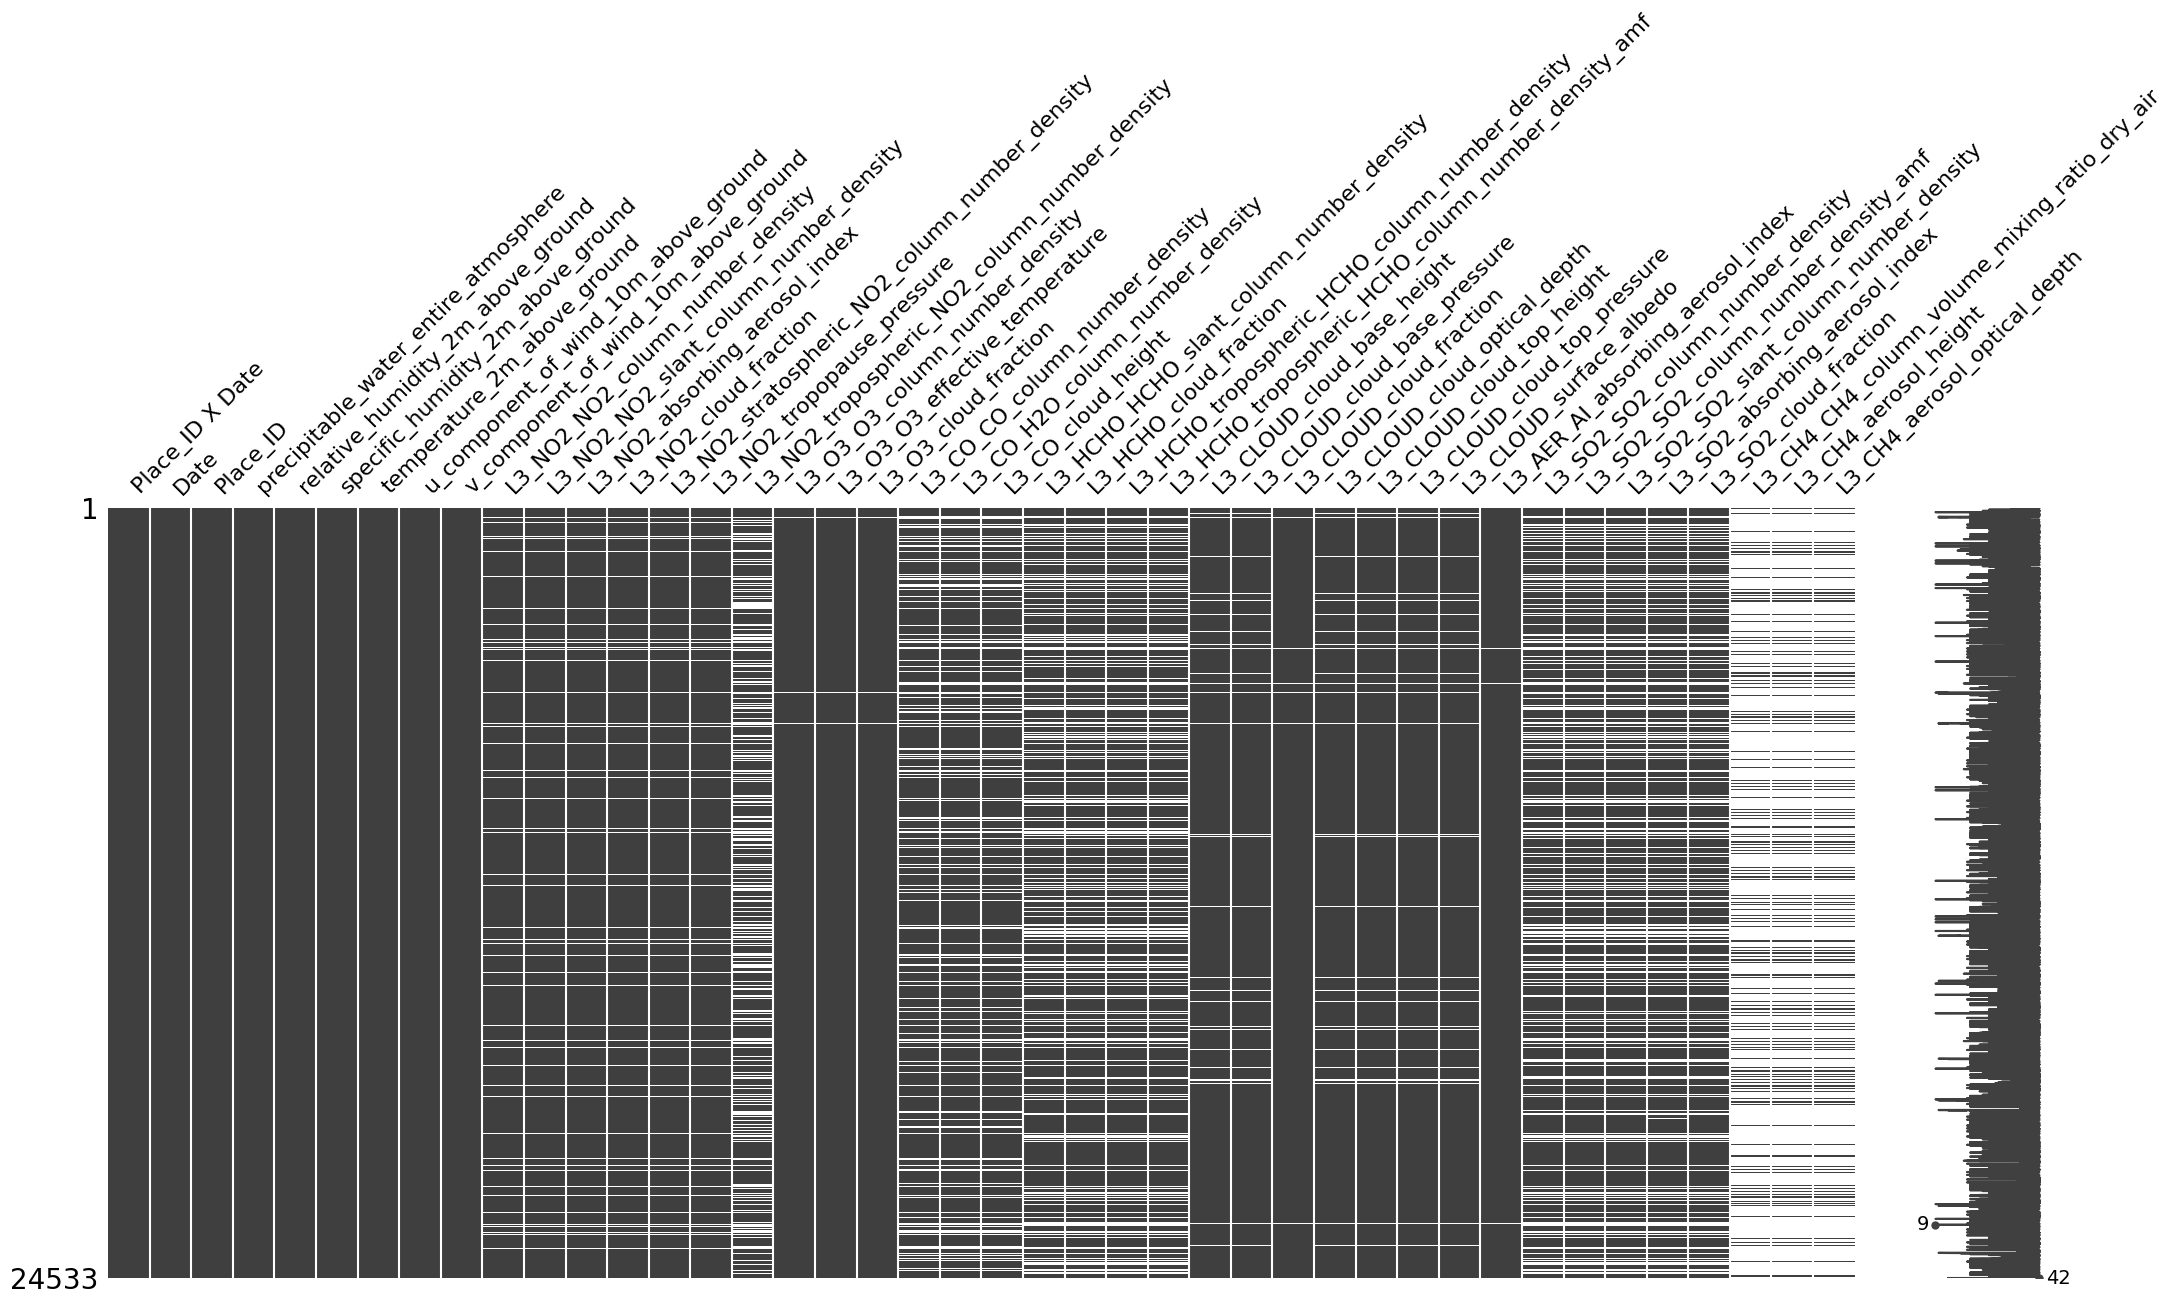

In [15]:
# assess missing values
msno.matrix(X_train)

<Axes: >

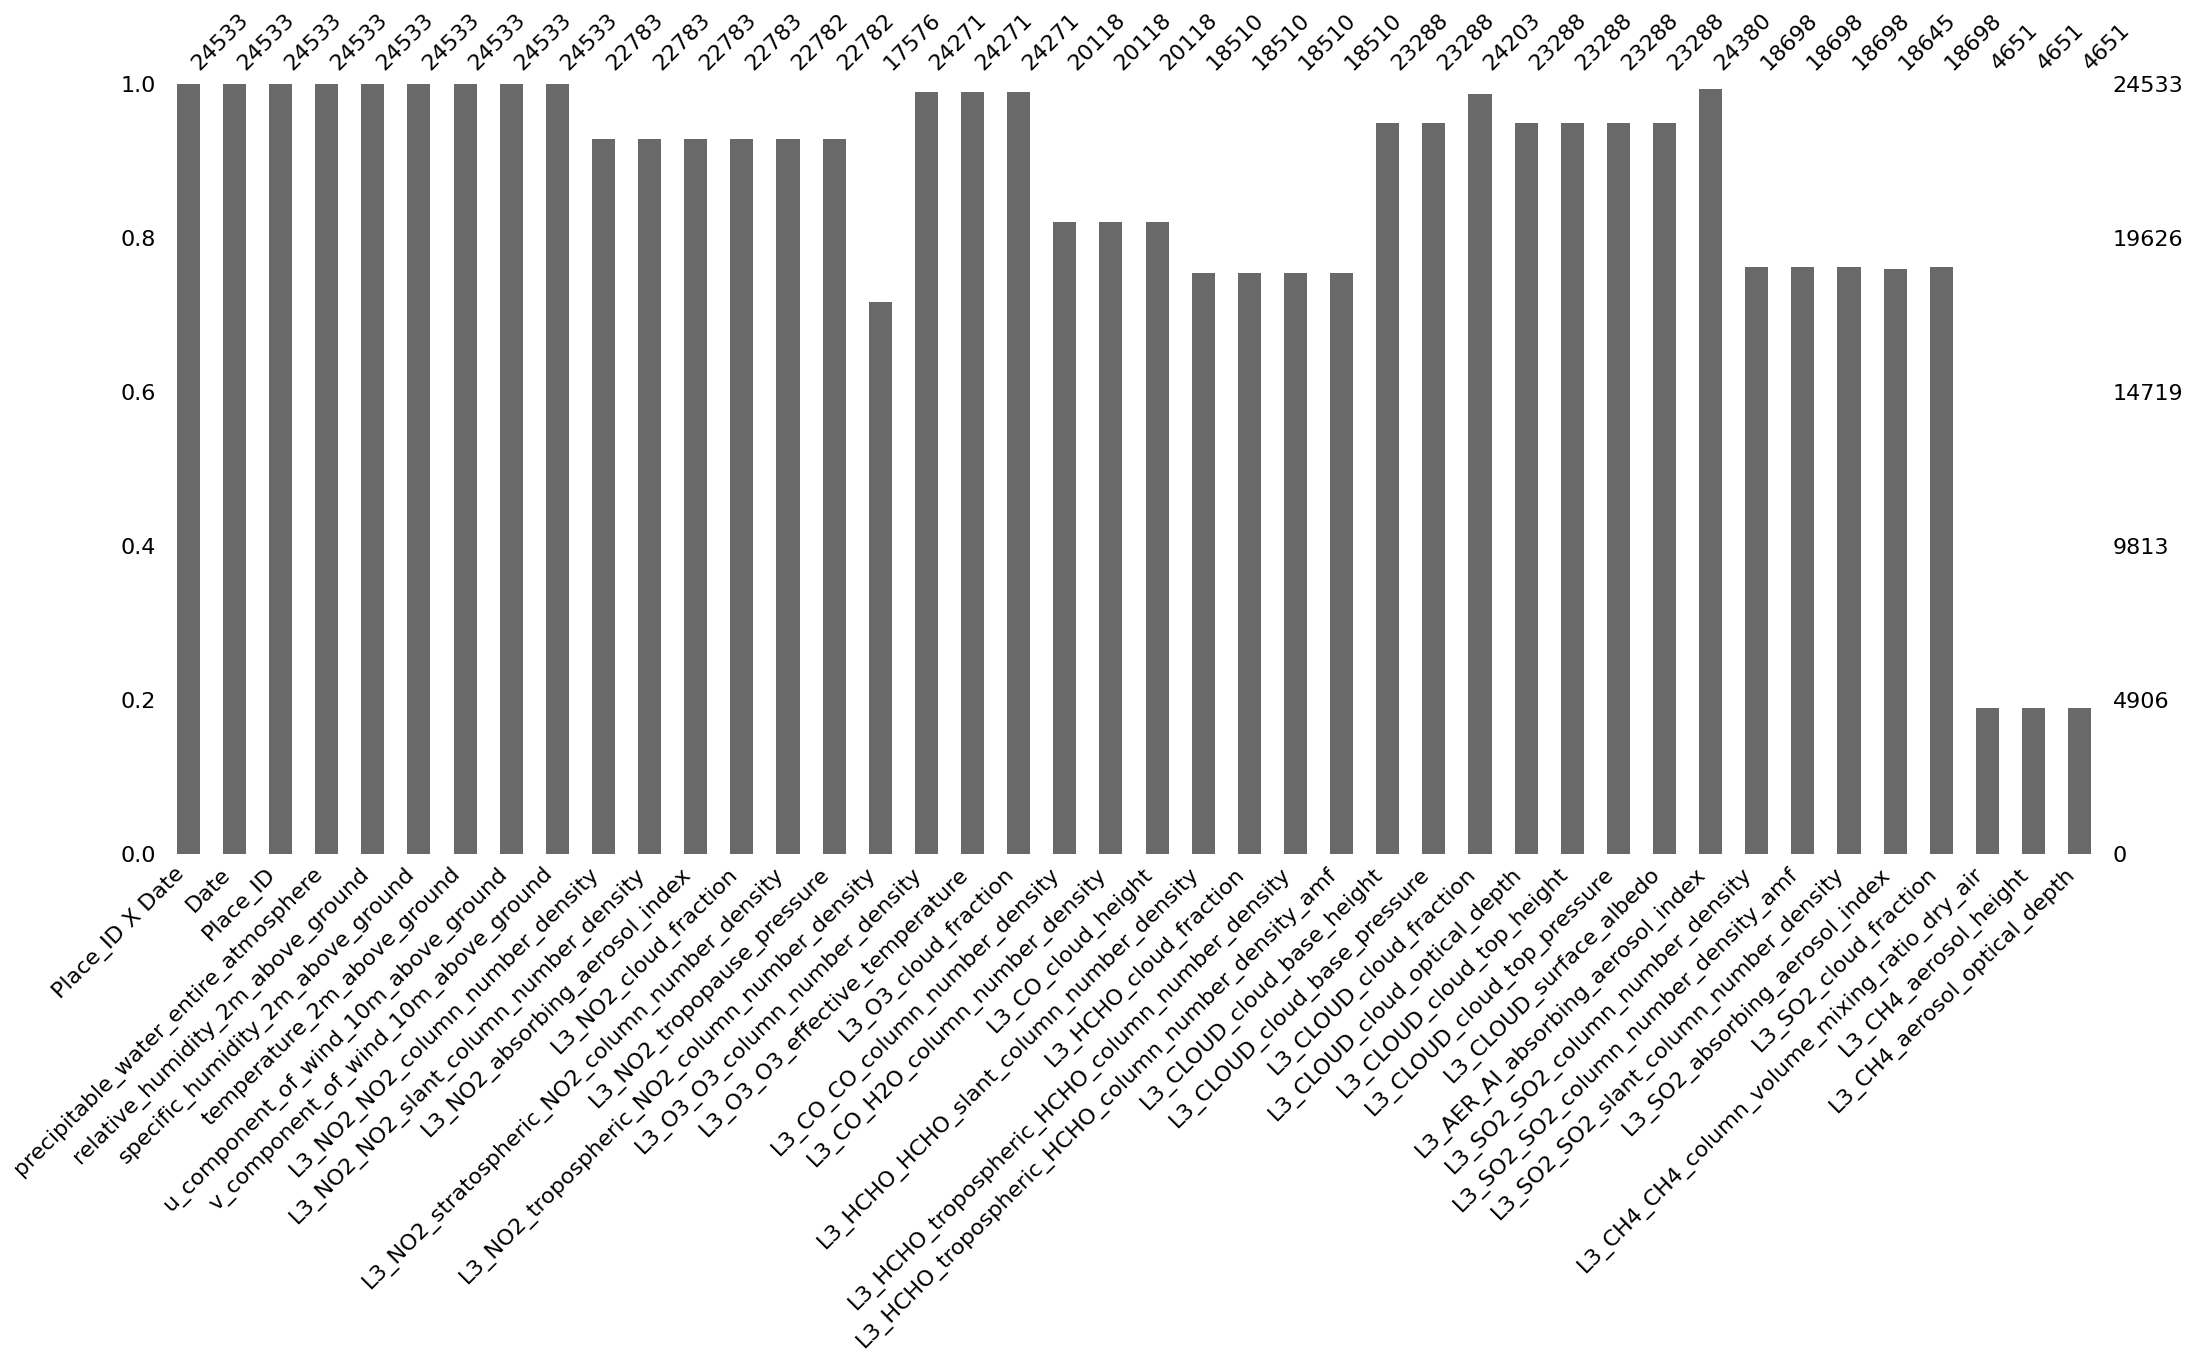

In [16]:
msno.bar(X_train)

## Dendrogram
From the dendrogram, we see that the majority of pollution data is either fully or highly coherent.
- location and weather data is coherent
- CLOUD data is coherent with the exception of L3_CLOUD_cloud_fraction
- NO2 data has highly coherent but not fully

<Axes: >

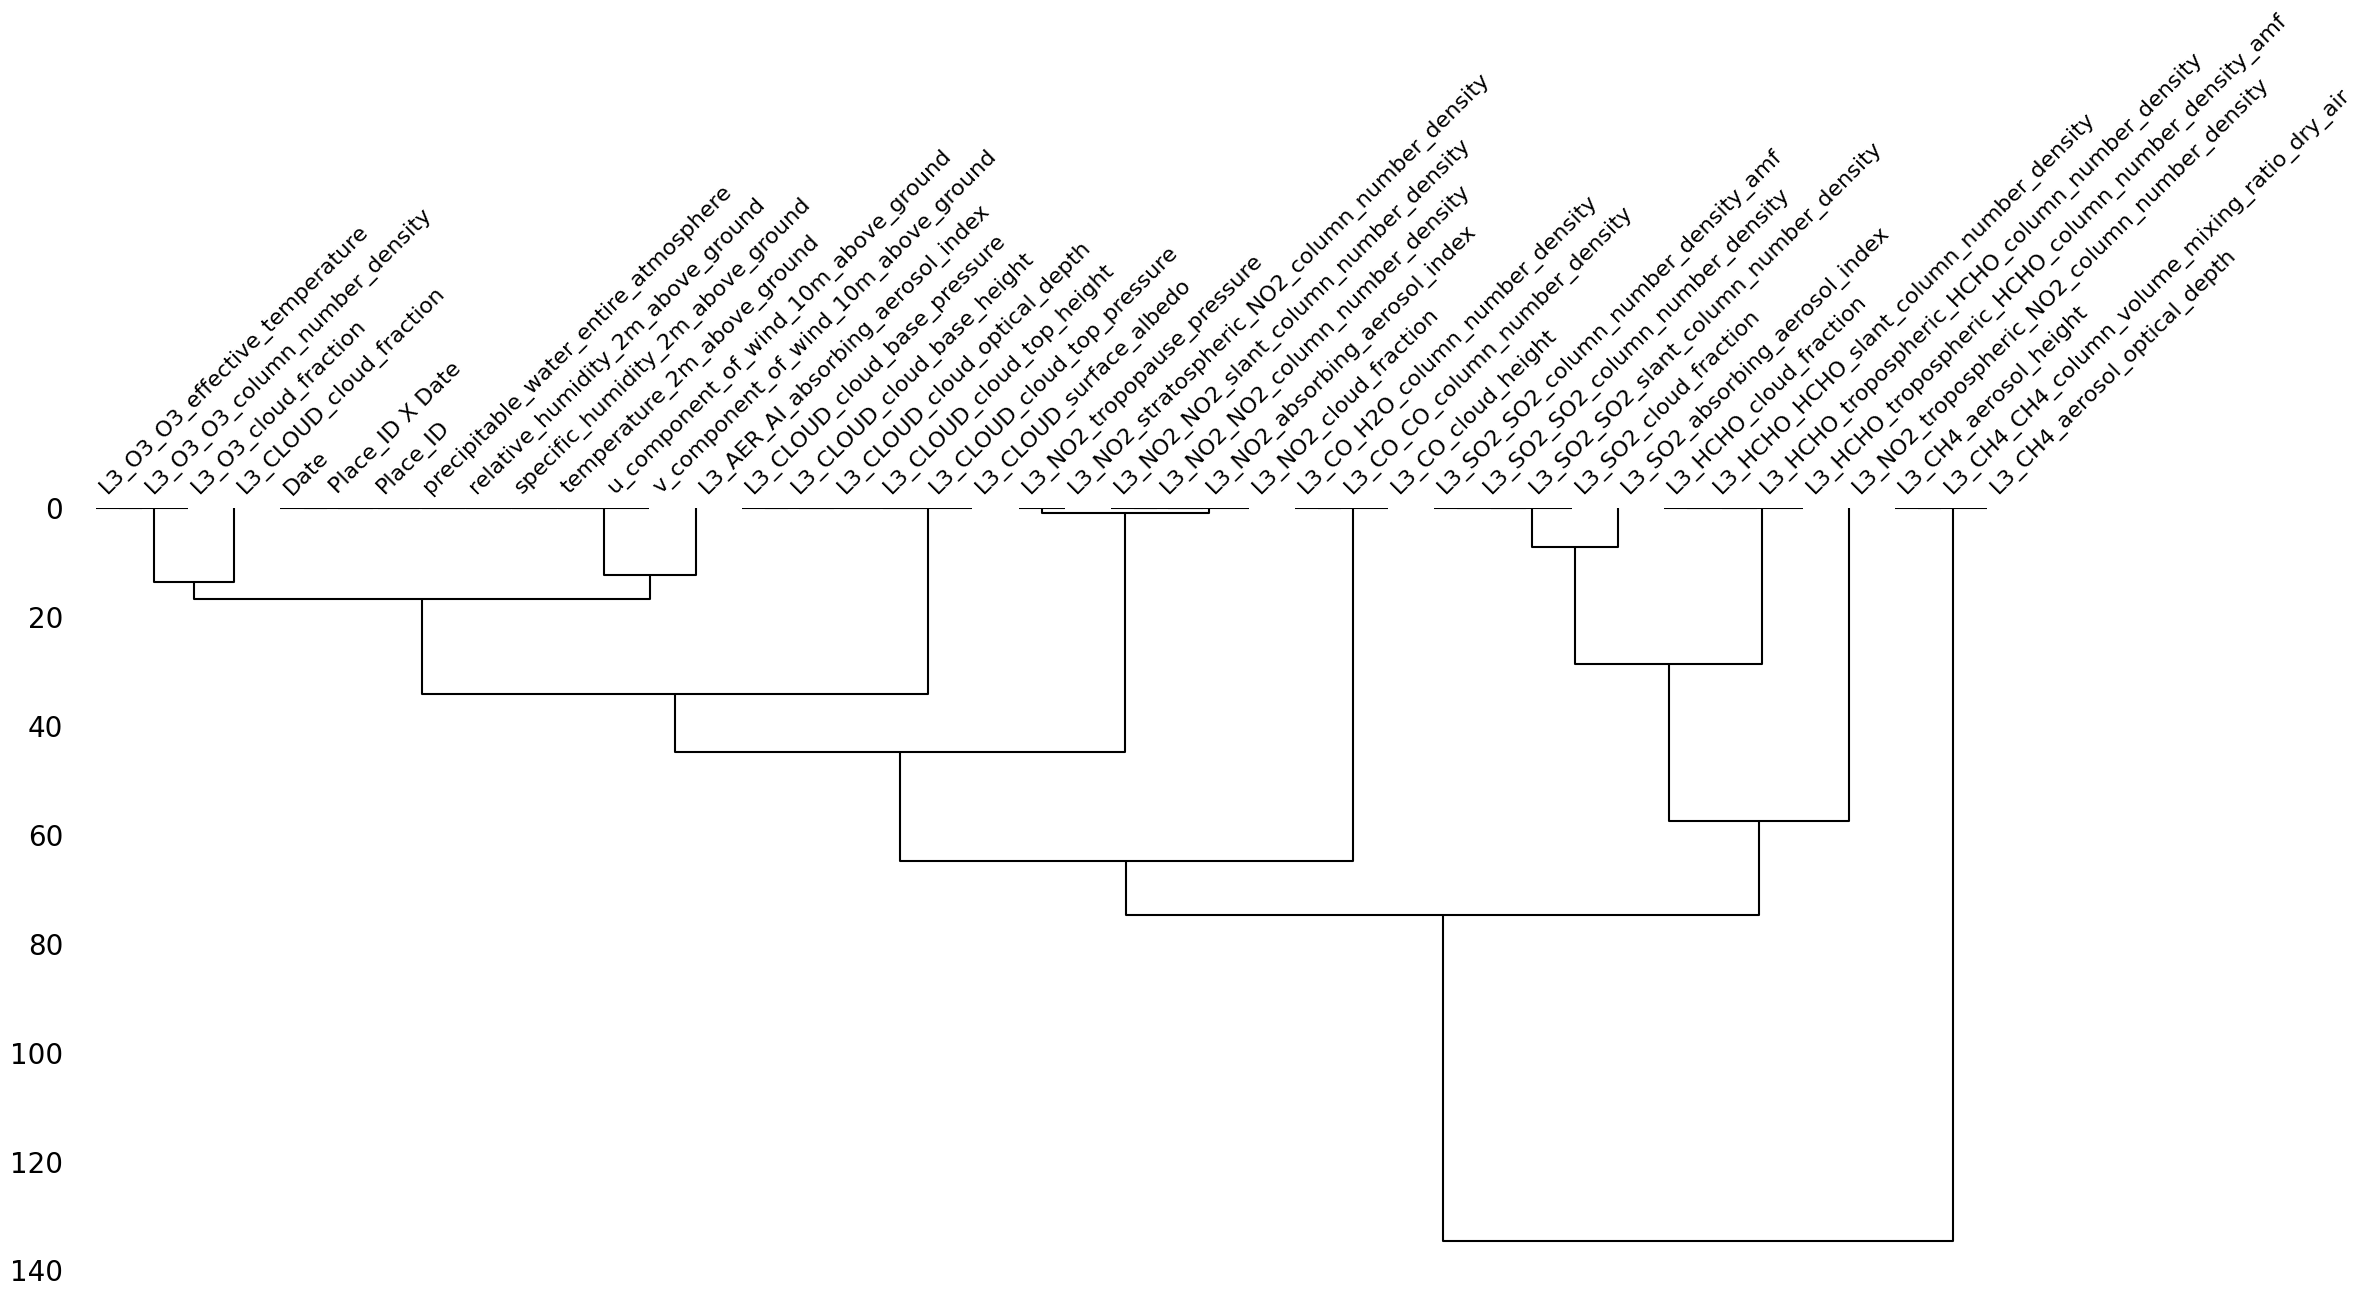

In [17]:
# The dendrogram plot provides a tree-like graph generated through hierarchical clustering and groups together columns 
# that have strong correlations in nullity.
msno.dendrogram(X_train)

In [18]:
# Nota bene: Robert Norris - L3_CO_cloud_height was dropped as it has a different dimension to the other features...
dendrogram_cluster=['L3_O3_cloud_fraction', 
                    'L3_CLOUD_cloud_fraction',
                    'L3_AER_AI_absorbing_aerosol_index',
                    'L3_CLOUD_surface_albedo',
                    'L3_NO2_stratospheric_NO2_column_number_density',
                    'L3_NO2_cloud_fraction',
                    #'L3_CO_cloud_height',
                    'L3_SO2_cloud_fraction',
                    'L3_SO2_absorbing_aerosol_index',
                    'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
                    'L3_NO2_tropospheric_NO2_column_number_density',
                    'L3_CH4_aerosol_optical_depth'
                    ]


In [19]:
X_train[dendrogram_cluster].describe()

,L3_O3_cloud_fraction,L3_CLOUD_cloud_fraction,L3_AER_AI_absorbing_aerosol_index,L3_CLOUD_surface_albedo,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_cloud_fraction,L3_SO2_cloud_fraction,L3_SO2_absorbing_aerosol_index,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_NO2_tropospheric_NO2_column_number_density,L3_CH4_aerosol_optical_depth
count,24271.000000,24203.000000,24380.000000,23288.000000,22782.000000,22783.000000,18698.000000,18645.000000,18510.000000,17576.000000,4651.000000
mean,0.426580,0.436291,-1.155892,0.229895,0.000032,0.279647,0.215490,-1.941958,1.065149,0.000056,0.015809
std,0.350955,0.351192,0.535284,0.104080,0.000013,0.304013,0.158893,0.710460,0.369274,0.000078,0.025873
min,0.000000,0.000000,-3.967332,0.015649,0.000000,0.000000,0.000000,-4.833706,0.000000,-0.000049,0.000000
25%,0.105515,0.112974,-1.509020,0.169402,0.000027,0.025101,0.076768,-2.371482,0.848074,0.000016,0.000000
50%,0.333081,0.346813,-1.169924,0.213115,0.000034,0.150102,0.192930,-1.953101,1.010440,0.000035,0.000000
75%,0.761982,0.775134,-0.811245,0.262323,0.000040,0.478747,0.348074,-1.550787,1.234625,0.000070,0.023498
max,1.000000,1.000000,4.824804,0.988804,0.000069,1.000000,0.618176,3.736877,3.099836,0.002055,0.210483


In [20]:
groups = X_train.sort_values(['Place_ID X Date']).groupby('Place_ID')

focus_place = random.choice(places_train)
highlighted_cluster = random.choice(dendrogram_cluster)
focus_df = groups.get_group(focus_place)

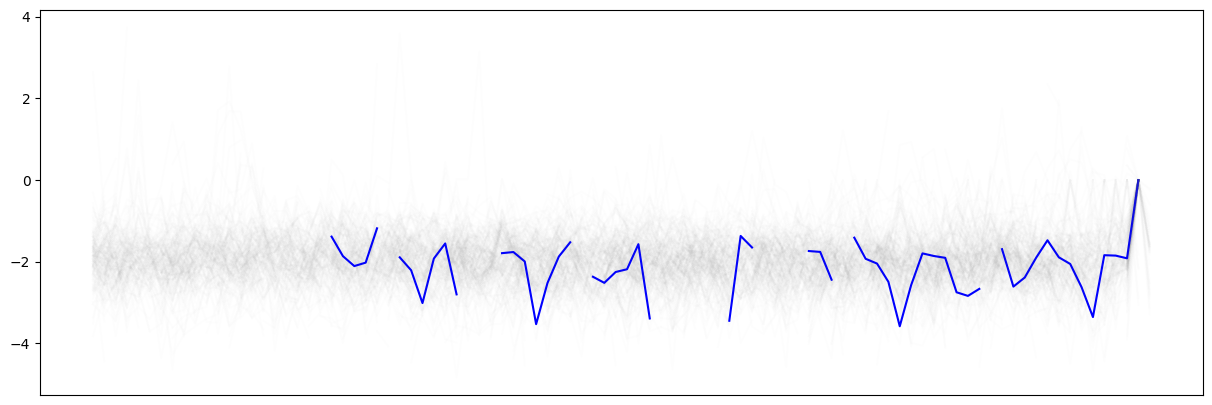

In [21]:
# Nota bene: Robert Norris - .gca is 'Get the current Axes' which combines all .plot onto same chart...

def plotFeatureHighlightingSinglePlace(
        groups: pd.core.groupby.generic.DataFrameGroupBy, 
        highlighted_place: str, 
        focus_feature: str):
    # Plot for a single feature, highlighting a single place
    for group in groups:
        place=group[0]
        df=group[1][[focus_feature] + ['Date']]
        df.plot(
            kind='line',
            x='Date', xticks=[], xlabel='', 
            figsize=[15,5], ax=plt.gca(),
            color='grey', alpha=0.01,
            legend=False)
        if place == highlighted_place:
            df.plot(
                kind='line',
                x='Date', xticks=[], xlabel='', 
                figsize=[15,5], ax=plt.gca(),
                color='blue',
                legend=False)
        
    plt.show()
            
plotFeatureHighlightingSinglePlace(groups, focus_place, highlighted_cluster)            


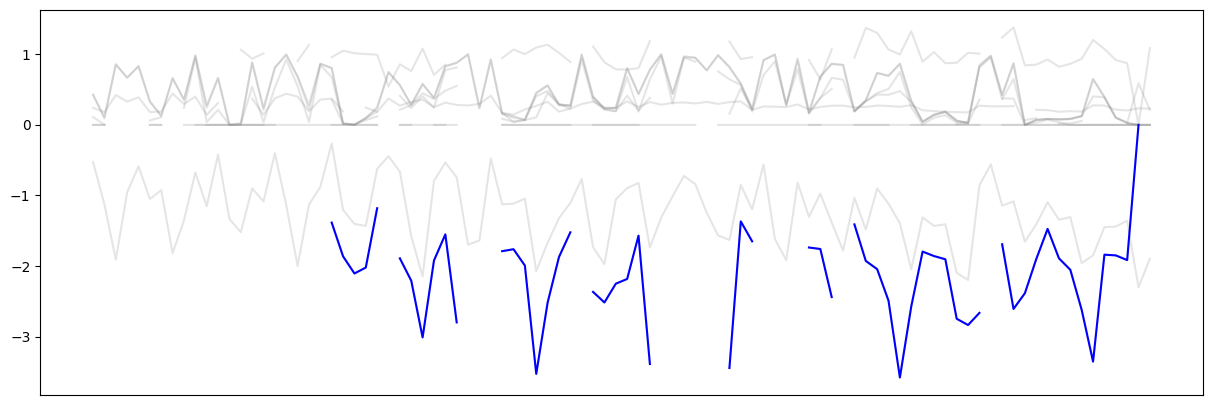

In [22]:
# Plot a single place, highlighting a single feature
def plotPlaceHighlightingSingleFeature(
    focus_df: pd.DataFrame,
    features: list[str], 
    highlighted_feature: str):
    focus_df[dendrogram_cluster + ['Date']].plot(
        kind='line',
        x='Date', xticks=[], xlabel='', 
        figsize=[15,5], ax=plt.gca(),
        color='grey', alpha=0.2,
        legend=False)
    # It is easier to plot all in grey and then choose a single one to highlight than mess with the 'color cycler'...
    focus_df[[highlighted_cluster] + ['Date']].plot(
        kind='line',
        x='Date', xticks=[], xlabel='', 
        figsize=[15,5], ax=plt.gca(),
        color='blue',
        legend=False)
    plt.show()

plotPlaceHighlightingSingleFeature(focus_df, dendrogram_cluster, highlighted_cluster)

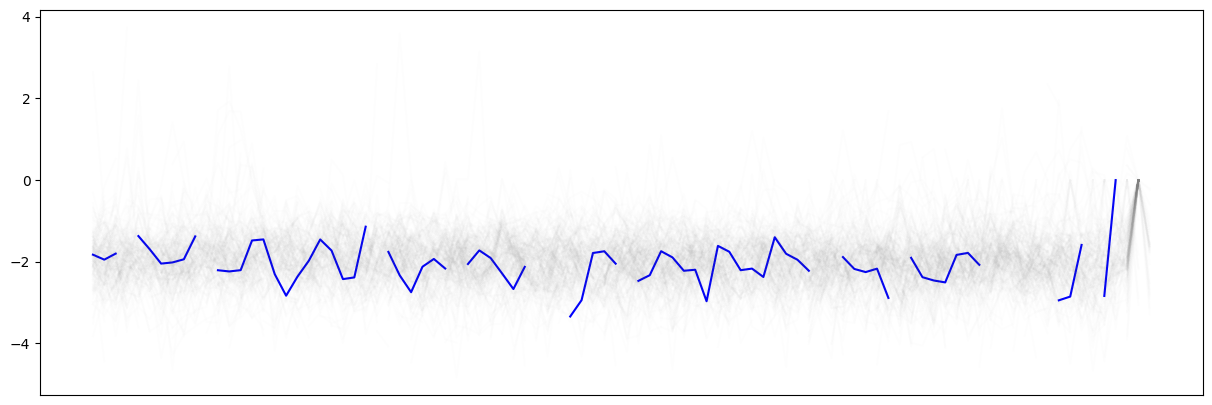

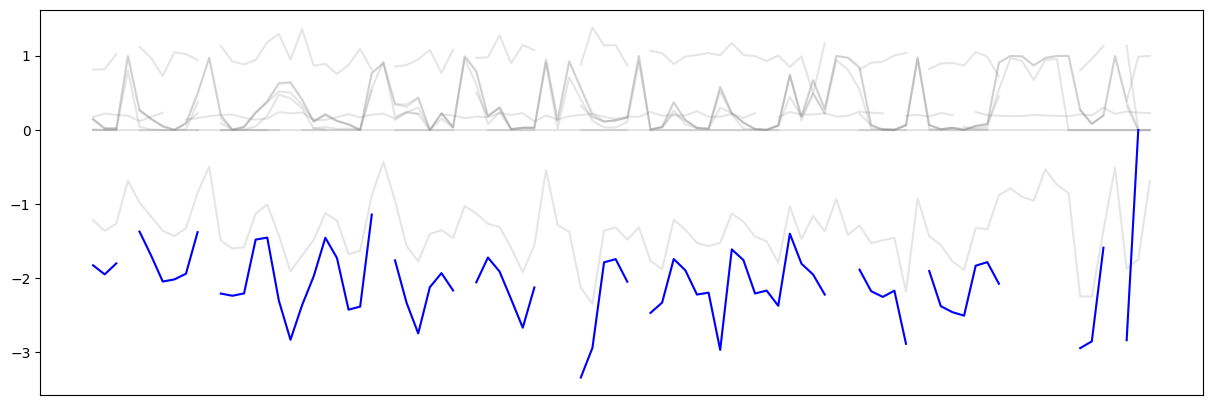

In [23]:
# example for a specific place and feature
sample_feature = 'L3_SO2_absorbing_aerosol_index'
sample_place = places_train[6]
sample_place_df = groups.get_group(sample_place)

plotFeatureHighlightingSinglePlace(groups, sample_place, sample_feature)  
plotPlaceHighlightingSingleFeature(sample_place_df, dendrogram_cluster, sample_feature)          


!!MK finished cleaning code here!!

In [24]:
counts_missing = X.groupby('Place_ID').count().sort_values('L3_CH4_aerosol_height')

counts_missing.head(5)

,Place_ID X Date,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
Place_ID,,,,,,,,,,,,,,,,,,,,,
5IUK9TG,3,3,3,3,3,3,3,3,1,1,...,0,0,0,0,0,0,0,0,0,0
WY9VXCA,57,57,57,57,57,57,57,57,57,57,...,55,55,55,1,1,1,1,1,1,1
MJSB8K5,7,7,7,7,7,7,7,7,7,7,...,5,5,5,1,1,1,1,1,1,1
S91MBTB,29,29,29,29,29,29,29,29,28,28,...,17,17,17,1,1,1,1,1,1,1
SX68COZ,80,80,80,80,80,80,80,80,80,80,...,66,66,66,2,2,2,2,2,2,2


### Imputation for missing values
- we decided to use linear interpolation on the level of a place. 
- This means we need to: 
    - order data by place and date
    - interpolate 

In [25]:
# linear imputation of missing values
X_train.sort_values(['Place_ID X Date'])
X_test.sort_values(['Place_ID X Date'])

# Stepwise imputation: 
# 1. linear interpolation by place (back and forward)

X_train_impute = X_train.groupby('Place_ID').apply(lambda group: group.interpolate(method='linear', limit_direction = 'both')).reset_index(drop = 1)
X_test_impute = X_test.groupby('Place_ID').apply(lambda group: group.interpolate(method='linear', limit_direction = 'both')).reset_index(drop = 1)

# 2. mean fill if no better option using simple imputer
impute_mean = SimpleImputer()
impute_mean.fit(X_train_impute[poll_cols])

X_train_impute[poll_cols] = impute_mean.transform(X_train_impute[poll_cols])
X_test_impute[poll_cols] = impute_mean.transform(X_test_impute[poll_cols])

# check on the one place for which we needed the simple imputer
# X_test_impute[X_test_impute.Place_ID == '5IUK9TG']


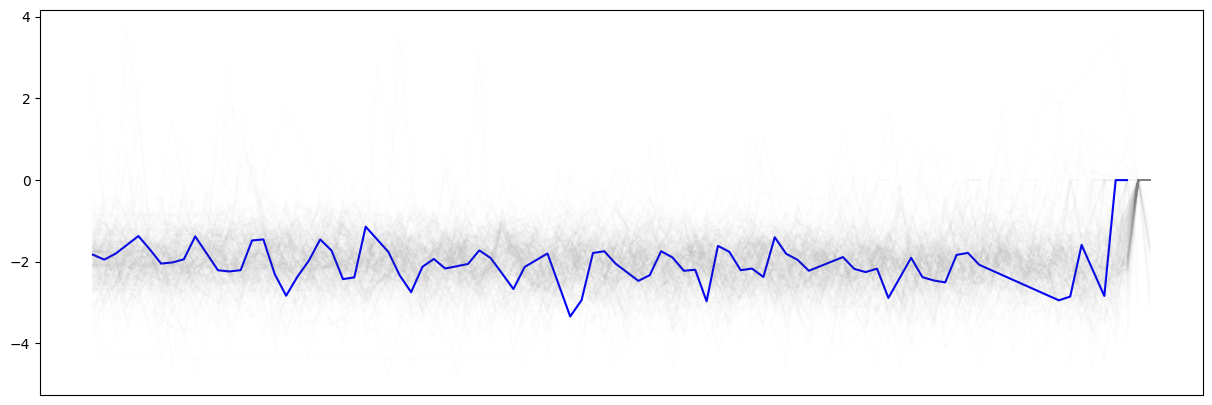

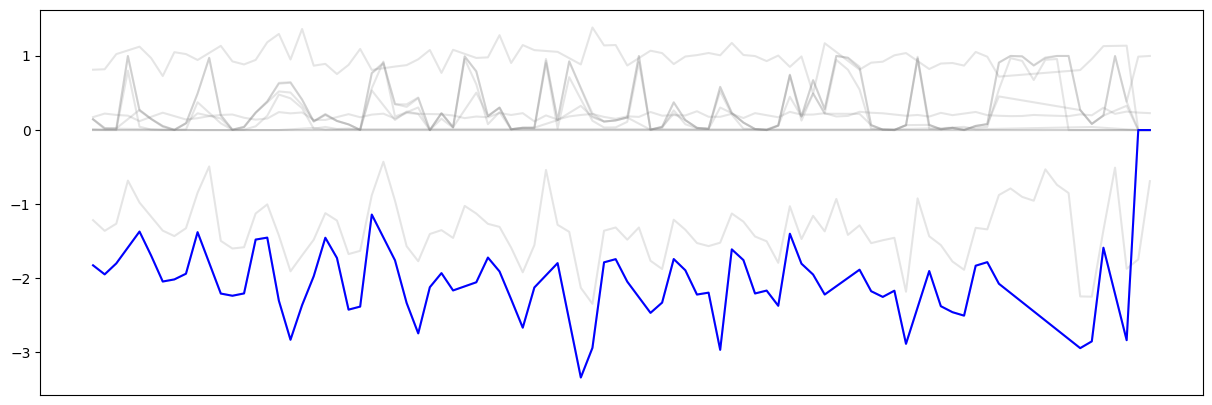

In [26]:
# Nota bene: Robert Norris - groupby seems to perform at least a partial copy so
# we must regroup after imputation...
X_train_impute_groups=X_train_impute.groupby('Place_ID')
place_df = X_train_impute_groups.get_group(sample_place)

plotFeatureHighlightingSinglePlace(X_train_impute_groups, sample_place, sample_feature)  
plotPlaceHighlightingSingleFeature(place_df, dendrogram_cluster, sample_feature)          

In [27]:
# check that there are no missing values
assert X_train_impute.isnull().sum().sum() == 0
assert X_test_impute.isnull().sum().sum() == 0

In [28]:
# replace dataset with imputed dataset
X_train = X_train_impute.copy()
X_test = X_test_impute.copy()

# 4. Modelling

## Pipelines

In [29]:
#---------------------------------------------------
# feature sets 

all_features = weather_cols + poll_cols 

#---------------------------------------------------
# pipelines

scaler = MinMaxScaler()

# linear model
lm = Pipeline([
    ('scaler', scaler),
    ('regressor', LinearRegression()) 
])

# polynomial model
pm = Pipeline([
    ('scaler', scaler), 
    ('tranformer', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# knn model
knn = Pipeline([
    ('scaler', scaler), # why this one? we can think about it more, could use standard scaler?
    ('regressor', KNeighborsRegressor())
])

# decision tree
dt = Pipeline([
    ('regressor', DecisionTreeRegressor())
])

# random forest
rf = None

# xgboost


#--------------------------------------------------------
# function definitions

def evaluate_model(model, features): 
    y_test_pred = model.predict(X_test[features])
    y_train_pred = model.predict(X_train[features])
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
    rmse_test  = mean_squared_error(y_test, y_test_pred, squared = False)

    print(f"R2 score on train: {round(r2_train, 3)}")
    print(f"R2 score on test: {round(r2_test, 3)}")
    print("---" * 10)
    print(f"RMSE on train: {round(rmse_train, 3)}")
    print(f"RMSE on test: {round(rmse_test, 3)}")

    return y_test_pred, y_train_pred, rmse_test

## Baseline model

- hypothesis: there is less PM2.5 in the atmosphere when it is windy
- method: OLS

- model
$$ y = b_0 + b_1 * x_1 + \epsilon $$

- estimated model
$$ \hat{PM}_{2.5} = \hat{b}_0 + \hat{b}_1 * wind $$


In [30]:
base_features = ['relative_humidity_2m_above_ground']

lm.fit(X_train[base_features], y_train)

y_pred_base, _, rmse_base = evaluate_model(lm, base_features)


R2 score on train: 0.004
R2 score on test: 0.005
------------------------------
RMSE on train: 47.252
RMSE on test: 44.474


Text(0, 0.5, 'pm2.5')

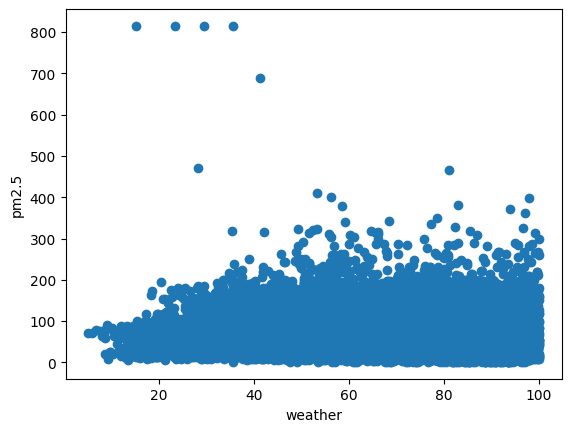

In [31]:
# plot y against X
plt.scatter(X_train[base_features], y_train)
plt.xlabel('weather')
plt.ylabel('pm2.5')

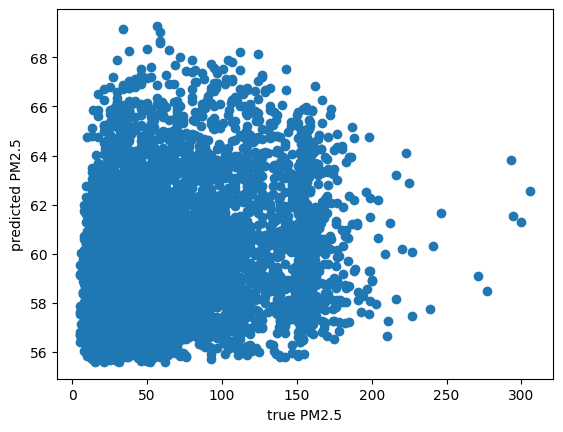

In [32]:
plt.scatter(y_test, y_pred_base)
plt.xlabel('true PM2.5')
plt.ylabel('predicted PM2.5')
plt.show()

## OLS with all features (scaled)

In [33]:
lm.fit(X_train[all_features], y_train)

y_pred_lm, _, rmse_lm = evaluate_model(lm, all_features)


R2 score on train: 0.362
R2 score on test: 0.37
------------------------------
RMSE on train: 37.822
RMSE on test: 35.405


## KNN regression (scaled)
- tried initially unscaled version with truly *horrible* results

In [34]:
knn.fit(X_train[all_features], y_train)

y_pred_knn, _, rmse_knn = evaluate_model(knn, all_features)


R2 score on train: 0.638
R2 score on test: 0.296
------------------------------
RMSE on train: 28.473
RMSE on test: 37.42


## Polynomial model

In [35]:
# pm.fit(X_train[all_features], y_train)

## Simple decision tree (scaled)

In [36]:
dt.fit(X_train[all_features], y_train)

y_pred_dt, _, rmse_dt = evaluate_model(dt, all_features)


R2 score on train: 1.0
R2 score on test: -0.131
------------------------------
RMSE on train: 0.0
RMSE on test: 47.435


#### DT Model selection

In [37]:
# splitters = ['best', 'random']
criterion = ['squared_error']
depths = [2,4,8]
splits = [2,4,8]
leaves = [4,8,16]
param_grid = {#"regressor__splitter": splitters,
              "regressor__criterion" : criterion,
              "regressor__max_depth" : depths,
              "regressor__min_samples_split": splits,
              "regressor__min_samples_leaf": leaves
             }
dt_gs = GridSearchCV(dt, param_grid,
                  cv=5, verbose=1, n_jobs=-1)

dt_gs.fit(X_train[all_features], y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error'],
                         'regressor__max_depth': [2, 4, 8],
                         'regressor__min_samples_leaf': [4, 8, 16],
                         'regressor__min_samples_split': [2, 4, 8]},
             verbose=1)

In [38]:
print('Best score:', round(dt_gs.best_score_, 3))
print('Best parameters:', dt_gs.best_params_)

y_pred_dt_gs, _, rmse_dt_gs = evaluate_model(dt_gs, all_features)

Best score: 0.28
Best parameters: {'regressor__criterion': 'squared_error', 'regressor__max_depth': 8, 'regressor__min_samples_leaf': 16, 'regressor__min_samples_split': 4}
R2 score on train: 0.516
R2 score on test: 0.309
------------------------------
RMSE on train: 32.938
RMSE on test: 37.059


## XGBoost regression

In [41]:
xgb = Pipeline([
    ('scaler', scaler),
    ('regressor', XGBRegressor())
])

In [40]:
xgb.fit(X_train[all_features], y_train)
y_pred_xgb, _, rmse_xgb = evaluate_model(xgb, all_features)

R2 score on train: 0.873
R2 score on test: 0.456
------------------------------
RMSE on train: 16.861
RMSE on test: 32.88


# Feature selection

## train model

In [121]:
xgb1 = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    seed=RSEED)

In [123]:
xgb1.fit(X_train[all_features], y_train)
y__, _, rmse__ = evaluate_model(xgb1, all_features)

R2 score on train: 0.937
R2 score on test: 0.513
------------------------------
RMSE on train: 11.921
RMSE on test: 31.126


## get set of best features

In [124]:
xgb1.feature_importances_
feature_imp = pd.DataFrame(
    {'features': all_features,
     'importance': xgb1.feature_importances_,
    }
)

feature_imp = feature_imp.sort_values('importance',ascending=False).head(20)
best_features = list(feature_imp.features)


## visualize

<BarContainer object of 20 artists>

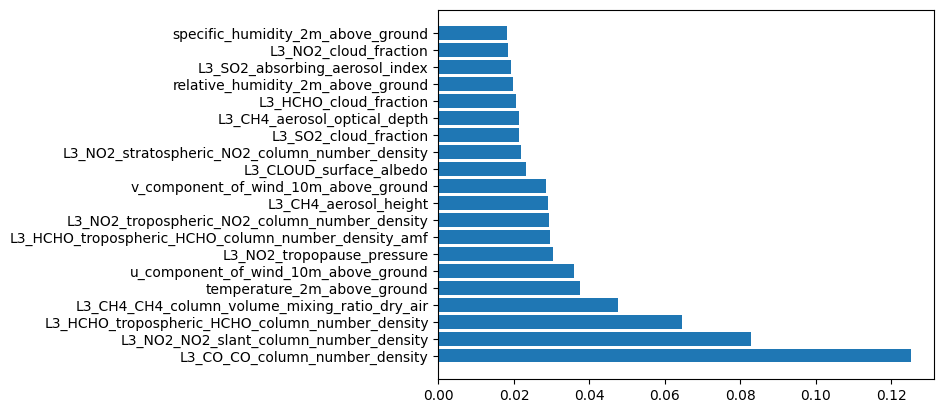

In [125]:
# plot best features
plt.barh(feature_imp.features, feature_imp.importance)

In [129]:
xgb1.fit(X_train[best_features], y_train)
y_xgb_bf, _, rmse_xgb_bf = evaluate_model(xgb1, best_features)

R2 score on train: 0.915
R2 score on test: 0.515
------------------------------
RMSE on train: 13.79
RMSE on test: 31.07


# Hyperparameter tuning

# step 1: find optimal max_depth and min_child_weight

In [164]:
param_test1 = {
 'n_estimators': [200],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2) 
}

gsearch1 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test1, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bi...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6, 2),
                         'n_estimators': [200]},
             verbose=1)

In [167]:
y_pred_gs1, _, rmse_gs1 = evaluate_model(gsearch1, best_features)
gsearch1.best_params_, gsearch1.best_score_

R2 score on train: 0.816
R2 score on test: 0.5
------------------------------
RMSE on train: 20.329
RMSE on test: 31.519


({'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200},
 0.4779174003009043)

zoom in on the specific parameters

In [149]:
param_test2 = {
 'n_estimators': [200],
 'max_depth':[6, 7, 8],
 'min_child_weight':[1,2]
}

gsearch2 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test2, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [1, 2],
                         'n_estimators': [200]},
             verbose=1)

In [150]:
print(gsearch2.best_params_, gsearch2.best_score_)
y_pred_gs2, _, rmse_gs2 = evaluate_model(gsearch2, best_features)

{'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200} 0.4779174003009043
R2 score on train: 0.816
R2 score on test: 0.5
------------------------------
RMSE on train: 20.329
RMSE on test: 31.519


## step 2: tune gamma

In [160]:
param_test3 = {
 'n_estimators': [200],
 'max_depth':[7],
 'min_child_weight':[1],
 'gamma': [i/100.0 for i in range(0,50, 5)]
}

gsearch3 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test3, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                   0.4, 0.45],
                         'max_depth': [7], 'min_child_weight': [1],
                         'n_estimators': [200]},
             verbose=1)

In [168]:
print(gsearch3.best_params_, gsearch3.best_score_)
y_pred_gs3, _, rmse_gs3 = evaluate_model(gsearch3, best_features)

{'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200} 0.47814004231595975
R2 score on train: 0.88
R2 score on test: 0.518
------------------------------
RMSE on train: 16.421
RMSE on test: 30.962


In [162]:
param_test4 = {
 'n_estimators': [200],
 'max_depth':[7],
 'min_child_weight':[1],
 'gamma': [0.2],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test4, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bi...
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'gamma': [0.2], 'max_depth': [7],
                         'min_child_weight': [1], 'n_estimators': [200],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             verbose=1)

In [169]:
print(gsearch4.best_params_, gsearch4.best_score_)
y_pred_gs4, _, rmse_gs4 = evaluate_model(gsearch4, best_features)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9} 0.4812929376593644
R2 score on train: 0.877
R2 score on test: 0.518
------------------------------
RMSE on train: 16.606
RMSE on test: 30.975


In [171]:
param_test5 = {
 'n_estimators': [200],
 'max_depth':[7],
 'min_child_weight':[1],
 'gamma': [0.2],
 'subsample':[0.8, 0.85, 0.9, 0.95, 1],
 'colsample_bytree':[0.5, 0.55, 0.6, 0.65, 0.7]
}

gsearch5 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test5, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch5.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bi...
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.55, 0.6, 0.65, 0.7],
                         'gamma': [0.2], 'max_depth': [7],
                         'min_child_weight': [1], 'n_estimators': [200],
                         'subsample': [0.8, 0.85, 0.9, 0.95, 1]},
             verbose=1)

In [172]:
print(gsearch5.best_params_, gsearch5.best_score_)
y_pred_gs5, _, rmse_gs5 = evaluate_model(gsearch5, best_features)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9} 0.4812929376593644
R2 score on train: 0.877
R2 score on test: 0.518
------------------------------
RMSE on train: 16.606
RMSE on test: 30.975


## step X: tune regularization parameters

In [174]:
param_test6 = {
 'n_estimators': [200],
 'max_depth':[7],
 'min_child_weight':[1],
 'gamma': [0.2],
 'subsample':[0.9],
 'colsample_bytree':[0.6],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test6, 
    verbose = 1, 
    n_jobs=-1,
    cv=5
)

gsearch6.fit(X_train[best_features], y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bi...
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=1000,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6], 'gamma': [0.2],
                         'max_depth': [7], 'min_child_weight': [1],
                         'n_estimators': [200],
                         'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                         'subsample': [0.9]},
             verbose=1)

In [175]:
print(gsearch6.best_params_, gsearch6.best_score_)
y_pred_gs6, _, rmse_gs6 = evaluate_model(gsearch6, best_features)

{'colsample_bytree': 0.6, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 100, 'subsample': 0.9} 0.481002660432942
R2 score on train: 0.858
R2 score on test: 0.519
------------------------------
RMSE on train: 17.868
RMSE on test: 30.928


# goals

next task: 
 - run polynomial (with grid search)

how to improve a model: 
 - improve model: 
    - feature selection: 
        - look into feature importance
    - Ridge/Lasso
        - can be done within XGB
    - hyperparameter tuning
        - could do Gridsearch/Randomsearch


 - interpret model 
 - can we predict quality in cities around the world? --> yes, but what are the limitations